In [42]:
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit.providers.ibmq import least_busy
#IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2022-08-12 14:28:27,164: Credentials already present. Set overwrite=True to overwrite.


In [30]:
# The circuit gate containing the unknown blackbox value
def genOracle(input):
    qc = QuantumCircuit(len(blackboxVal)+1) #one extra qubit for calculation
    
    for i, val in enumerate(reversed(blackboxVal)):
        if val == '1':
            qc.cx(i, len(blackboxVal))
    
    return qc

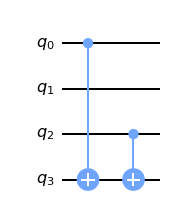

In [47]:
blackboxVal = '101'
qc = genOracle(blackboxVal)
qc.draw(output='mpl')

In [48]:
def bernsteinVaz(val):
    qc = QuantumCircuit(len(val)+1, len(val)) #one extra qubit for calculation
    
    qc.h(range(len(val)))
    
    qc.x(len(val))
    qc.h(len(val))

    oracle = genOracle(val)
    oracle = oracle.to_gate()
    oracle.name = "Oracle"
    qc.append(oracle, range(len(val) + 1))

    qc.h(range(len(val)))

    qc.measure(range(len(val)), range(len(val)))
    
    return qc

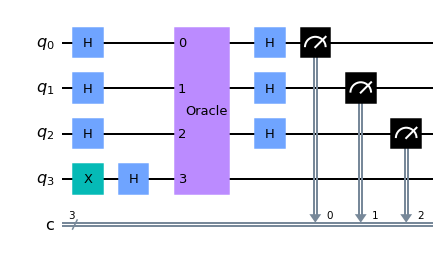

In [49]:
qc = bernsteinVaz(blackboxVal)
qc.draw(output='mpl')

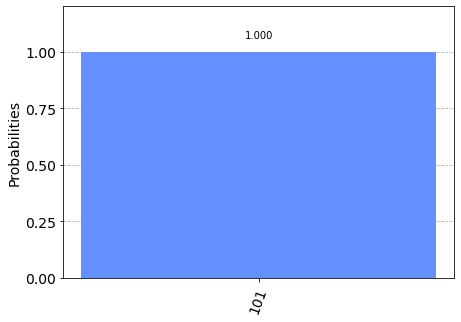

In [50]:
sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = sim, shots = 1024).result()
counts = result.get_counts()
plot_histogram(counts)

In [51]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= len(blackboxVal)+1 and
                                      not x.configuration().simulator and x.status().operational==True))

print("Least busy: ", backend)

%qiskit_job_watcher

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

Least busy:  ibm_oslo


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

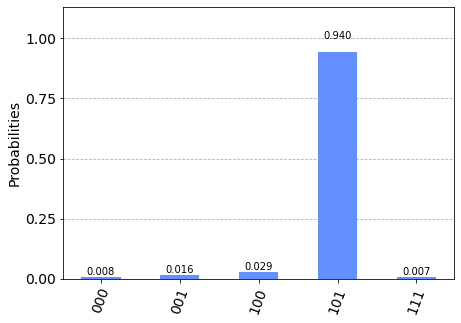

In [52]:
counts = job.result().get_counts()
plot_histogram(counts)